In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import ParameterGrid

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load CIFAR-100 dataset
dataset = CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR100(root='./data', train=False, download=True, transform=transform)

# Split dataset into training and validation subsets
validation_ratio = 0.1
val_size = int(validation_ratio * len(dataset))
train_size = len(dataset) - val_size
train_data, val_data = random_split(dataset, [train_size, val_size])

# Function to create the ResNet model
def create_model():
    model = models.resnet18(pretrained=False)  # Use pretrained=True for transfer learning
    model.fc = nn.Linear(model.fc.in_features, 100)  # Modify the final layer for CIFAR-100
    return model.to(device)

# Function to train the model
def train_model(model, criterion, optimizer, train_loader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# Function to validate the model
def validate_model(model, criterion, val_loader):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Validation Accuracy: {100 * accuracy:.2f}%")
    return accuracy

# Function to test the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Test Accuracy: {100 * accuracy:.2f}%")
    return accuracy

# GridSearch with Cross-Validation
def grid_search(param_grid):
    best_params = None
    best_accuracy = 0.0
    grid = ParameterGrid(param_grid)

    for params in grid:
        print(f"Testing params: {params}")

        # DataLoaders with different batch sizes
        train_loader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True, num_workers=4)
        val_loader = DataLoader(val_data, batch_size=params['batch_size'], shuffle=False, num_workers=4)

        # Create model, loss function, and optimizer
        model = create_model()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['lr'])

        # Train and validate
        train_model(model, criterion, optimizer, train_loader, num_epochs=params['num_epochs'])
        val_accuracy = validate_model(model, criterion, val_loader)

        # Update best parameters if current parameters perform better
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params

    print(f"Best Parameters: {best_params}")
    print(f"Best Validation Accuracy: {100 * best_accuracy:.2f}%")
    return best_params

# Hyperparameter Grid
param_grid = {
    'lr': [0.001, 0.01],
    'batch_size': [32, 64],
    'num_epochs': [10, 30]
}

# Perform GridSearch
best_params = grid_search(param_grid)

# Test the model with the best parameters
best_model = create_model()
train_loader = DataLoader(train_data, batch_size=best_params['batch_size'], shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

# Train the model with the best parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=best_params['lr'])
train_model(best_model, criterion, optimizer, train_loader, num_epochs=best_params['num_epochs'])

# Test the model
test_model(best_model, test_loader)

Files already downloaded and verified
Files already downloaded and verified
Testing params: {'batch_size': 32, 'lr': 0.001, 'num_epochs': 10}
Epoch [1/10], Loss: 3.9235
Epoch [2/10], Loss: 3.2102
Epoch [3/10], Loss: 2.6626
Epoch [4/10], Loss: 2.2048
Epoch [5/10], Loss: 1.8248
Epoch [6/10], Loss: 1.5098
Epoch [7/10], Loss: 1.1927
Epoch [8/10], Loss: 0.8768
Epoch [9/10], Loss: 0.5642
Epoch [10/10], Loss: 0.3472
Validation Accuracy: 52.06%
Testing params: {'batch_size': 32, 'lr': 0.001, 'num_epochs': 30}
Epoch [1/30], Loss: 3.9604
Epoch [2/30], Loss: 3.2922
Epoch [3/30], Loss: 2.6570
Epoch [4/30], Loss: 2.1726
Epoch [5/30], Loss: 1.8053
Epoch [6/30], Loss: 1.5020
Epoch [7/30], Loss: 1.1956
Epoch [8/30], Loss: 0.8955
Epoch [9/30], Loss: 0.6105
Epoch [10/30], Loss: 0.3846
Epoch [11/30], Loss: 0.2470
Epoch [12/30], Loss: 0.1933
Epoch [13/30], Loss: 0.1677
Epoch [14/30], Loss: 0.1435
Epoch [15/30], Loss: 0.1309
Epoch [16/30], Loss: 0.1155
Epoch [17/30], Loss: 0.1073
Epoch [18/30], Loss: 0.099

0.5208

In [ ]:
torch.save(best_model, "best_model.pth")

In [2]:
import torch
best_model = torch.load("best_model.pth")

<ipython-input-2-2e3cbffaaec9>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load("best_model.pth")


Files already downloaded and verified


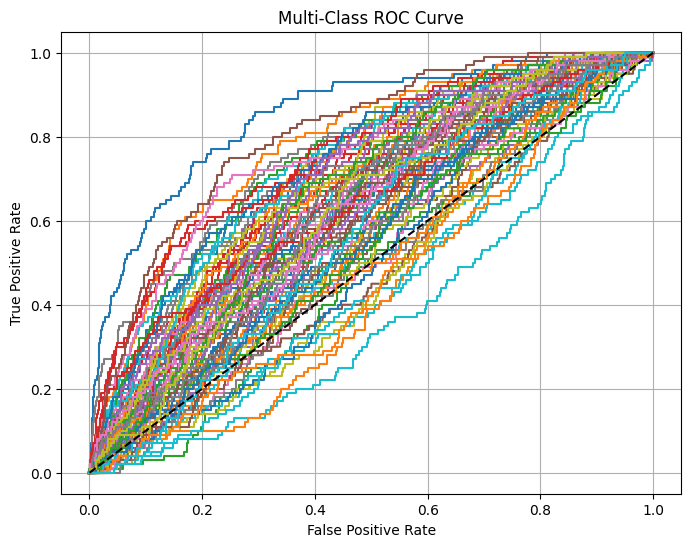

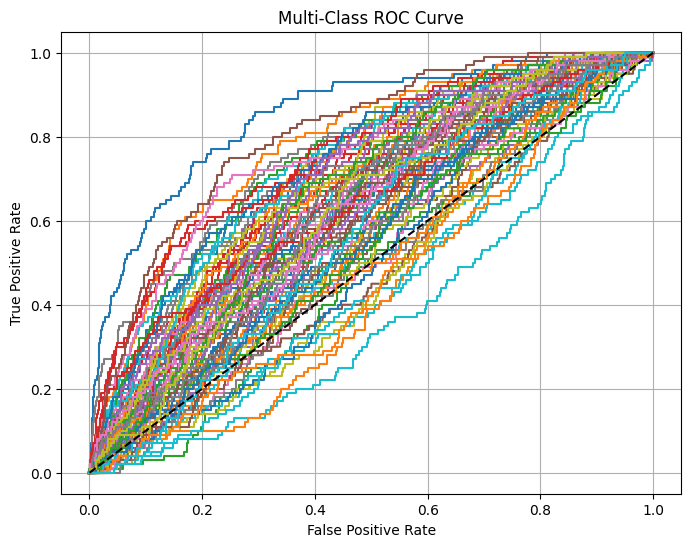

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_dataset = CIFAR100(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

y_true = []
y_scores = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)  # Output logits
        probabilities = torch.nn.Softmax(dim=1)(outputs)  # Convert logits to probabilities
        y_scores.extend(probabilities.cpu().numpy())  # Store probabilities for all classes
        y_true.extend(labels.cpu().numpy())  # Store true labels

# Convert `y_true` to one-hot encoding
n_classes = len(np.unique(y_true))
y_true_one_hot = label_binarize(y_true, classes=range(n_classes))

y_scores = np.array(y_scores)  # Convert list to numpy array

# Compute ROC AUC for multi-class
roc_auc = roc_auc_score(y_true_one_hot, y_scores, multi_class='ovr')

# Compute ROC Curve for each class
fpr = {}
tpr = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_one_hot[:, i], y_scores[:, i])

# Plotting
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.grid()
plt.show()
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.grid()
plt.show()

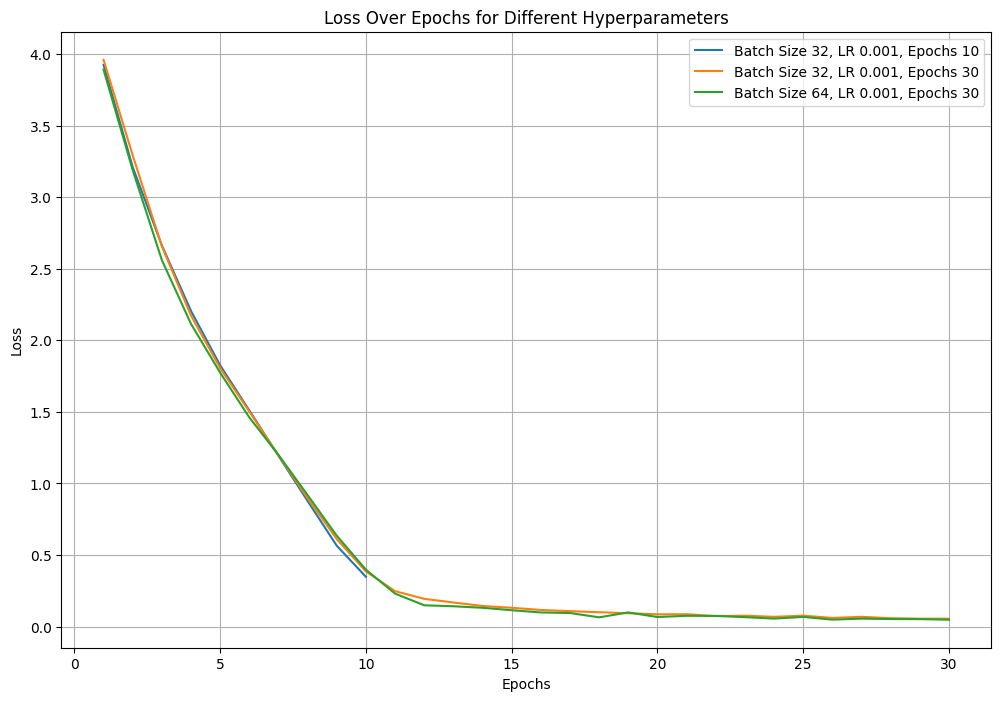

In [10]:
import matplotlib.pyplot as plt

# Data for different hyperparameters
results = {
    "Batch Size 32, LR 0.001, Epochs 10": {
        "epochs": list(range(1, 11)),
        "loss": [3.9235, 3.2102, 2.6626, 2.2048, 1.8248, 1.5098, 1.1927, 0.8768, 0.5642, 0.3472],
    },
    "Batch Size 32, LR 0.001, Epochs 30": {
        "epochs": list(range(1, 31)),
        "loss": [3.9604, 3.2922, 2.6570, 2.1726, 1.8053, 1.5020, 1.1956, 0.8955, 0.6105, 0.3846,
                 0.2470, 0.1933, 0.1677, 0.1435, 0.1309, 0.1155, 0.1073, 0.0998, 0.0928, 0.0851,
                 0.0860, 0.0728, 0.0756, 0.0676, 0.0756, 0.0600, 0.0676, 0.0580, 0.0547, 0.0547],
    },
    "Batch Size 64, LR 0.001, Epochs 30": {
        "epochs": list(range(1, 31)),
        "loss": [3.8909, 3.1885, 2.5606, 2.1143, 1.7734, 1.4610, 1.1990, 0.9178, 0.6342, 0.3969,
                 0.2298, 0.1482, 0.1415, 0.1308, 0.1138, 0.0982, 0.0943, 0.0641, 0.0984, 0.0662,
                 0.0747, 0.0740, 0.0653, 0.0554, 0.0671, 0.0479, 0.0551, 0.0521, 0.0516, 0.0474],
    },
}

# Plotting
plt.figure(figsize=(12, 8))
for label, data in results.items():
    plt.plot(data["epochs"], data["loss"], label=label)

plt.title("Loss Over Epochs for Different Hyperparameters")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


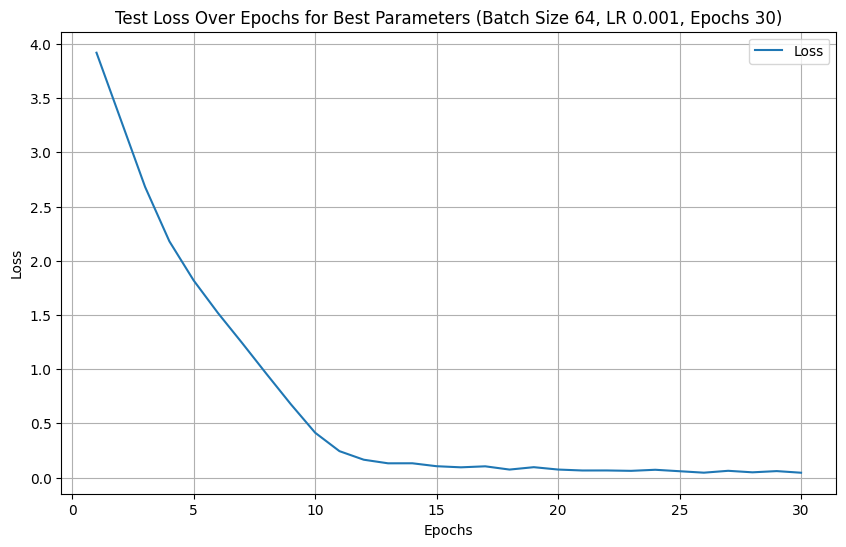

In [11]:
import matplotlib.pyplot as plt

# Data for the best parameters
best_params_label = "Batch Size 64, LR 0.001, Epochs 30"
best_params_data = {
    "epochs": list(range(1, 31)),
    "loss": [3.9191, 3.3008, 2.6814, 2.1795, 1.8183, 1.5179, 1.2399, 0.9555, 0.6764, 0.4139,
             0.2439, 0.1649, 0.1317, 0.1320, 0.1049, 0.0947, 0.1040, 0.0740, 0.0960, 0.0742,
             0.0655, 0.0658, 0.0622, 0.0721, 0.0587, 0.0453, 0.0626, 0.0486, 0.0598, 0.0449],
}

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(best_params_data["epochs"], best_params_data["loss"], label="Loss")
plt.title("Test Loss Over Epochs for Best Parameters (Batch Size 64, LR 0.001, Epochs 30)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()